<a href="https://colab.research.google.com/github/AlexSbb/Text-Generation-with-RNN-and-GAN/blob/main/CS13ColabNotebooks/LSTM_Text_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all necessary libraries:

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import time
import math
import random
print('TensorFlow version (should be 2.4.1):  ',tf.__version__)

TensorFlow version (should be 2.4.1):   2.4.1


# Open, read and process the text file
In our case the we use the log file from an Elevator Group Control System simulation - "ElevatorLogFile.txt"

In [ ]:
PATH_TO_FILE = "/content/drive/MyDrive/Colab Notebooks/CS13ColabNotebooks/ElevatorLogFile.txt"

# Open and read the whole txt file
def open_and_read_test_file (path :str):
    with open(path) as text_file:
        text = text_file.read()
    print('Number of characters in the log file:', len(text))
    print('Number of words in the log file (with whitespace as a splitter):', len(text.split()))
    return text

file_text = open_and_read_test_file(PATH_TO_FILE)

Number of characters in the log file: 73037
Number of words in the log file (with whitespace as a splitter): 9010


Creating a dictionary from a text file. 
We will use a character-level dictionary. To do this, you need to count the number of unique characters in the text file. Each character is then assigned a unique sequence number. As a result, we will get two dictionaries, one for converting characters to numbers, and the second for reverse conversion.

In [ ]:
def dictionary_from_text(text:str):
  set_of_uniq_ch = set(text) # set of uniq characters from text
  print('Number of uniq characters in the log file:', len(set_of_uniq_ch))
  char_to_index = {char:index for index, char in enumerate(set_of_uniq_ch)}
  index_to_char = {index:char for char,index in char_to_index.items()}
  return char_to_index, index_to_char

char_to_index, index_to_char =  dictionary_from_text(file_text)

Number of uniq characters in the log file: 54


In order to make it convenient to use dictionaries, I will create two auxiliary functions, for converting text to numbers and for reverse conversion.

In [ ]:
def text_to_numbers(dictionary: dict, text: str):
  numbers = [dictionary[char] for char in text]
  return numbers

def numbers_to_text(dictionary: dict, numbers: list):
  text =""
  for num in numbers:
    # text += str(dictionary[num])
    text += dictionary[num]
  return text

Now we can easily convert our entire text file to numbers

In [ ]:
whole_text_as_numbers = text_to_numbers(char_to_index, file_text)

# Test:
first_64_numbers = whole_text_as_numbers[0:64]
print("First 64 numberst from 'whole_text_as_numbers':")
print(first_64_numbers)
# test reverse conversion
reverse_conversion = numbers_to_text(index_to_char, first_64_numbers)
print("Conversin from numbers to text:")
print(reverse_conversion)

First 64 numberst from 'whole_text_as_numbers':
[19, 49, 25, 7, 15, 18, 17, 33, 15, 51, 51, 50, 33, 47, 19, 49, 25, 7, 15, 18, 17, 33, 15, 51, 51, 50, 33, 25, 33, 50, 14, 16, 32, 48, 48, 48, 27, 1, 49, 25, 31, 14, 11, 11, 50, 18, 20, 50, 33, 47, 19, 49, 25, 35, 50, 18, 50, 33, 14, 17, 0, 18, 20, 25]
Conversin from numbers to text:
0: Controller_0: Controller ready...
1: Passenger_0: Generating 


To create a text generator, there are two ways to divide a sequence into x (input) and y(output, labels):
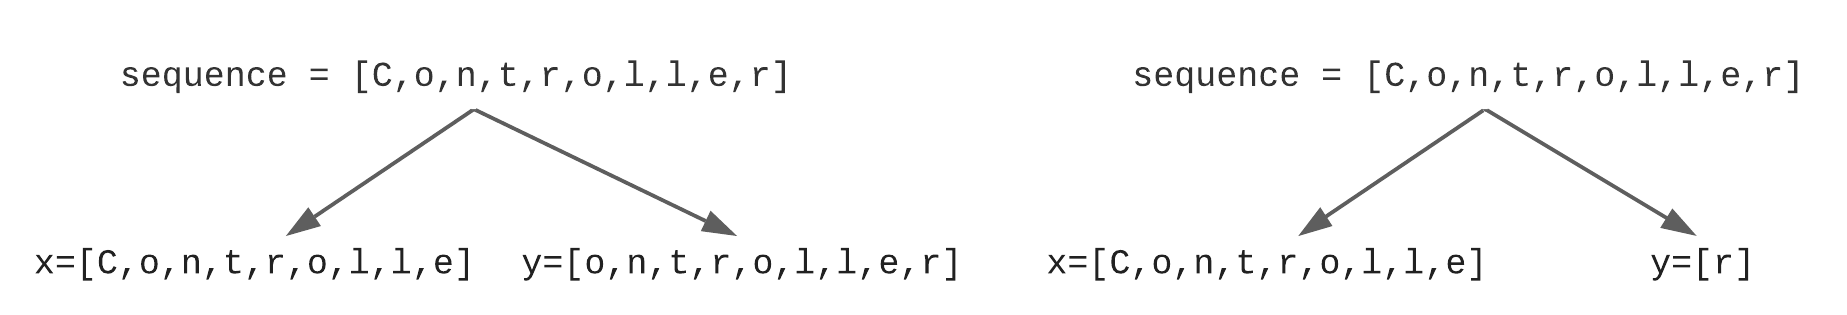


In [ ]:
#Split the input sequence into x and y, where x and y have the same shape
def split_to_x_y(sequence: list, x_length: int = 128, step: int = 3):
    x = []
    y = []
    for i in range(0, len(sequence) - x_length, step):
        x.append(np.array(sequence[i: i + x_length]) )
        y.append(np.array(sequence[i+1:i+1 + x_length]))
    print("Number of sequences:", len(x))
    x = np.array(x)
    y = np.array(y)   
    print('x.shape=', x.shape)
    print('y.shape=', y.shape)
    return x , y

# Left one last element in a sequence
def take_last_element(original_y: np.array):
  y_1 = [y[-1] for y in original_y]
  y_1 = np.array(y_1) 
  print('y_1.shape=', y_1.shape)
  return y_1

x, y = split_to_x_y(whole_text_as_numbers, x_length = 128, step = 3)
y_1 = take_last_element(y)

Number of sequences: 24303
x.shape= (24303, 128)
y.shape= (24303, 128)
y_1.shape= (24303,)


# Important note about  the LSTM layer

In [ ]:
input = tf.random.normal(shape=(2,128,54))
input.shape

TensorShape([2, 128, 54])

In [ ]:
lstm_v1 = tf.keras.layers.LSTM(8)
output = lstm_v1(input)
output.shape

TensorShape([2, 8])

In [ ]:
lstm_v2 = tf.keras.layers.LSTM(8,return_sequences=True)
whole_seq_output = lstm_v2(input)
print("whole_seq_output.shape", whole_seq_output.shape)

whole_seq_output.shape (2, 128, 8)


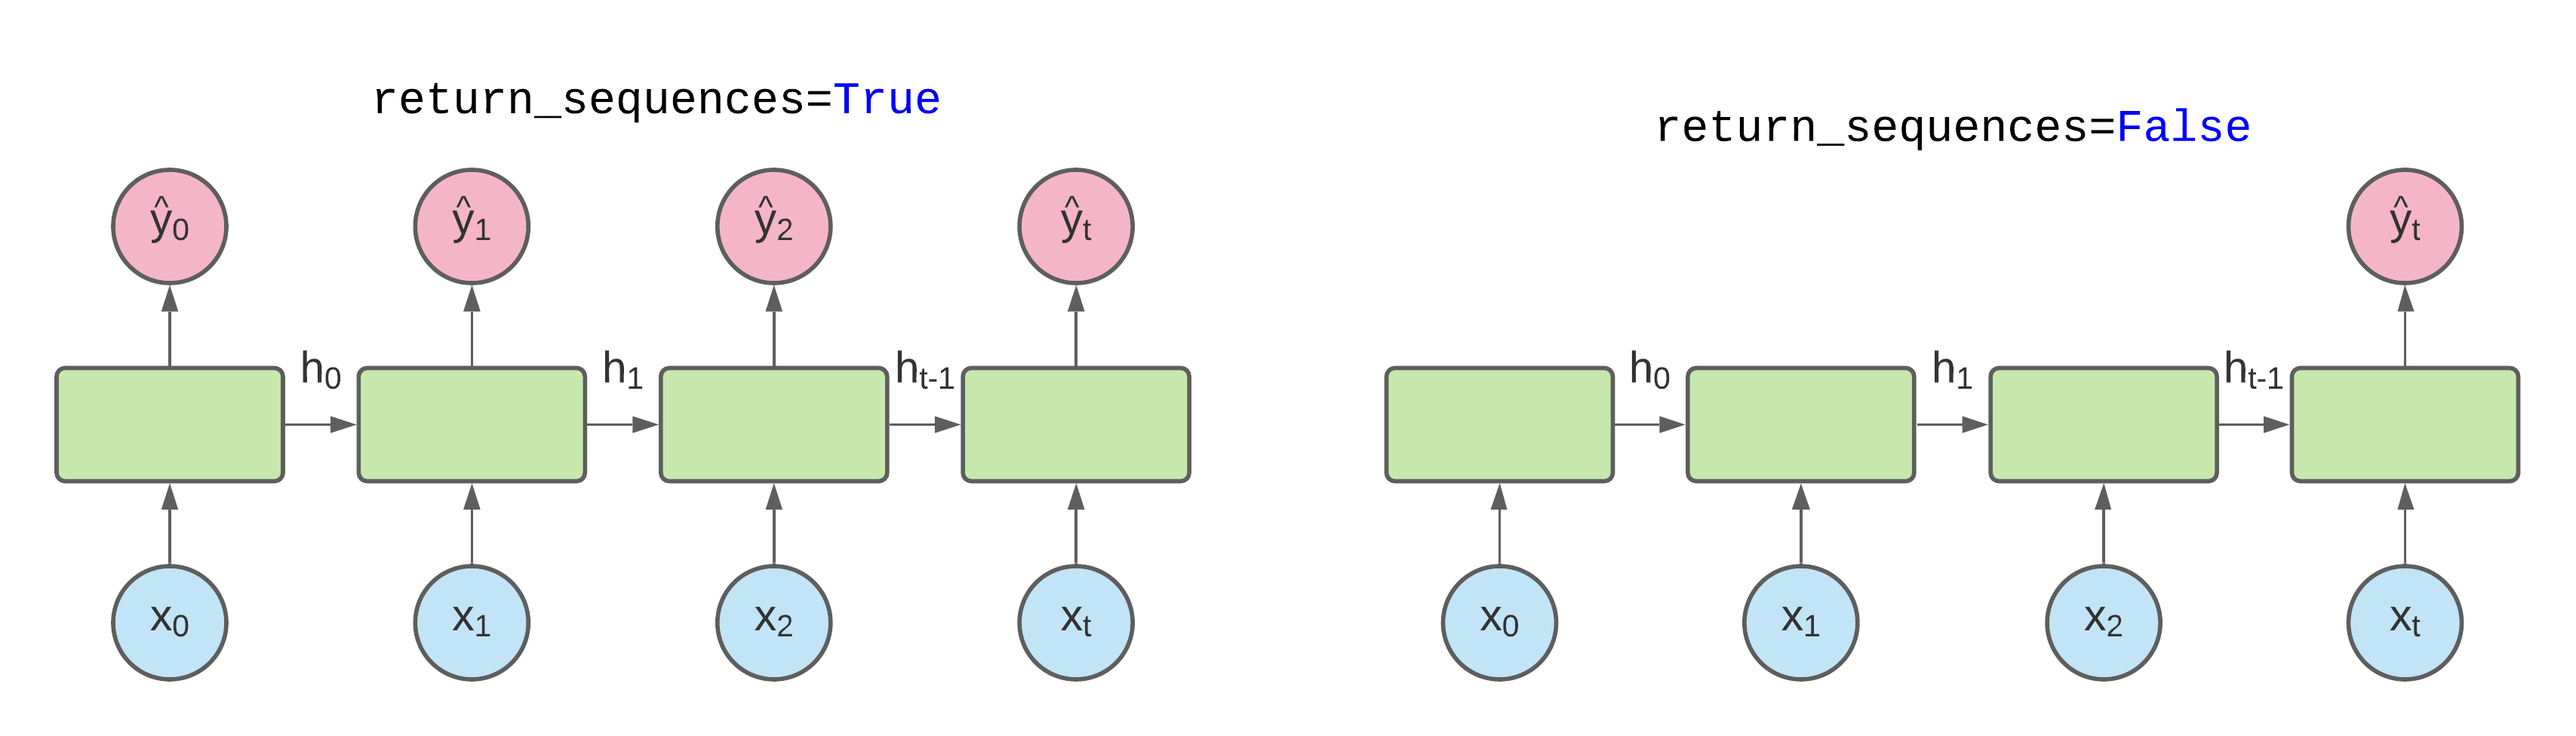

In [ ]:
lstm_v3 = tf.keras.layers.LSTM(8,return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm_v3(input)
print("whole_seq_output.shape  ",    whole_seq_output.shape)
print("final_memory_state.shape",  final_memory_state.shape)
print("final_carry_state.shape ",   final_carry_state.shape)

whole_seq_output.shape   (2, 128, 8)
final_memory_state.shape (2, 8)
final_carry_state.shape  (2, 8)


# One-hot encoding

In [ ]:
dictionary_lenth = len(index_to_char)
one_hot_matrix = np.eye(dictionary_lenth)
print('one_hot_matrix.shape=', one_hot_matrix.shape)

def array_of_seq_to_one_hot(array_of_seq:np.array, matrix: np.array):
  one_hot_seq = np.array(
    [np.array([matrix[:,ind] for ind in seq]) for seq in array_of_seq]
    )
  return one_hot_seq

def array_of_int_to_one_hot(array_of_int:np.array, matrix: np.array):
  one_hot_seq = np.array(
    np.array([matrix[:,ind] for ind in array_of_int])
    )
  return one_hot_seq

one_hot_x = array_of_seq_to_one_hot(x,one_hot_matrix)
one_hot_y = array_of_seq_to_one_hot(y,one_hot_matrix)

one_hot_y_1 = array_of_int_to_one_hot(y_1,one_hot_matrix)

print('one_hot_x.shape:', one_hot_x.shape, "# (batch_size, sequence_length, vocab_size)")
print('one_hot_y.shape:', one_hot_y.shape)
print('one_hot_y_1.shape:', one_hot_y_1.shape)

one_hot_matrix.shape= (54, 54)
one_hot_x.shape: (24303, 128, 54) # (batch_size, sequence_length, vocab_size)
one_hot_y.shape: (24303, 128, 54)
one_hot_y_1.shape: (24303, 54)


# Text generator version 1, (LSTM with default setting )

In [ ]:
text_generator_v1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(dictionary_lenth, activation="softmax")
])

Checking the model output shape:

In [ ]:
samlpe_input = one_hot_x[0:1]
samlpe_output = text_generator_v1(samlpe_input)
samlpe_output.shape

TensorShape([1, 54])

In [ ]:
text_generator_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 100)                  62000     
_________________________________________________________________
dense (Dense)                (1, 100)                  10100     
_________________________________________________________________
dense_1 (Dense)              (1, 54)                   5454      
Total params: 77,554
Trainable params: 77,554
Non-trainable params: 0
_________________________________________________________________


In [ ]:
text_generator_v1.compile(optimizer='adam', loss=tf.losses.categorical_crossentropy)
text_generator_v1.fit(x = one_hot_x, y = one_hot_y_1, epochs=12)

Epoch 1/12
760/760 [==============================] - 7s 7ms/step - loss: 2.6159
Epoch 2/12
760/760 [==============================] - 5s 7ms/step - loss: 0.8067
Epoch 3/12
760/760 [==============================] - 5s 7ms/step - loss: 0.5704
Epoch 4/12
760/760 [==============================] - 5s 7ms/step - loss: 0.4654
Epoch 5/12
760/760 [==============================] - 5s 7ms/step - loss: 0.4230
Epoch 6/12
760/760 [==============================] - 5s 7ms/step - loss: 0.4039
Epoch 7/12
760/760 [==============================] - 5s 7ms/step - loss: 0.3731
Epoch 8/12
760/760 [==============================] - 5s 7ms/step - loss: 0.3717
Epoch 9/12
760/760 [==============================] - 5s 7ms/step - loss: 0.3464
Epoch 10/12
760/760 [==============================] - 5s 7ms/step - loss: 0.3518
Epoch 11/12
760/760 [==============================] - 5s 7ms/step - loss: 0.3352
Epoch 12/12
760/760 [==============================] - 5s 7ms/step - loss: 0.3278


In [ ]:
start_text = 'Controller ready..'
pred_lenth = 300

# Convert start test to numbers
encoded_start_text=text_to_numbers(char_to_index, start_text)

gen_seq = encoded_start_text
for _ in range(pred_lenth):
  # print(gen_seq)
  one_hot_gen_seq = np.array([array_of_int_to_one_hot(gen_seq, one_hot_matrix)])  
  one_hot_pred = text_generator_v1(one_hot_gen_seq)  
  pred_array = tf.squeeze(one_hot_pred).numpy()
  
  # greedy sampling!!!!
  pred = np.array(np.argmax(pred_array), ndmin=1)
  
  # pred = [np.random.choice(dictionary_lenth, p=pred_array)]
  
  # print(pred)
  gen_seq = np.append(gen_seq, pred)

gen_text = numbers_to_text(index_to_char, gen_seq)
print(gen_text)



Controller ready...
1000.46: Passenger_14: Arriving with destination floor: 1
1000.46: Passenger_24: Passenger arriving at floor: 0
1000.46: Passenger_24: Passenger arriving at floor: 0
1000.46: Passenger_24: Passenger arriving at floor: 0
1000.46: Passenger_24: Passenger arriving at floor: 0
1000.46: Passenger_24: P


# Text generator version 2, (LSTM with  return_sequences=True) 

In [ ]:
text_generator_v2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(dictionary_lenth, activation="softmax")
])

Checking the model output shape:

In [ ]:
samlpe_input = one_hot_x[0:1]
samlpe_output = text_generator_v2(samlpe_input)
samlpe_output.shape

TensorShape([1, 128, 54])

In [ ]:
text_generator_v2.compile(optimizer='adam', loss=tf.losses.categorical_crossentropy)
text_generator_v2.fit(x = one_hot_x, y = one_hot_y, epochs=12)

Epoch 1/12
760/760 [==============================] - 10s 11ms/step - loss: 1.8652
Epoch 2/12
760/760 [==============================] - 8s 11ms/step - loss: 0.4025
Epoch 3/12
760/760 [==============================] - 8s 11ms/step - loss: 0.3483
Epoch 4/12
760/760 [==============================] - 8s 11ms/step - loss: 0.3204
Epoch 5/12
760/760 [==============================] - 8s 11ms/step - loss: 0.2998
Epoch 6/12
760/760 [==============================] - 8s 11ms/step - loss: 0.2812
Epoch 7/12
760/760 [==============================] - 8s 11ms/step - loss: 0.2629
Epoch 8/12
760/760 [==============================] - 8s 11ms/step - loss: 0.2417
Epoch 9/12
760/760 [==============================] - 8s 11ms/step - loss: 0.2258
Epoch 10/12
760/760 [==============================] - 8s 11ms/step - loss: 0.2095
Epoch 11/12
760/760 [==============================] - 8s 11ms/step - loss: 0.1940
Epoch 12/12
760/760 [==============================] - 8s 11ms/step - loss: 0.1813


In [ ]:
start_text = 'Controller ready'
encoded_start_text=text_to_numbers(char_to_index, start_text)
one_hot_start_text = np.array([array_of_int_to_one_hot(encoded_start_text, one_hot_matrix)])
one_hot_pred = text_generator_v2(one_hot_start_text)  
pred_array = tf.squeeze(one_hot_pred).numpy()
print('pred_array.shape',pred_array.shape)

ids = [np.argmax(seq) for seq in pred_array]
gen_text = numbers_to_text(index_to_char, ids)
print("Generated text:", gen_text)

pred_array.shape (16, 54)
Generated text: ontroller_ready.


In [ ]:
last_ch_v2 = pred_array[-1]
last_ch_v2

In [ ]:
pred_lenth = 300

# Convert start test to numbers
encoded_start_text=text_to_numbers(char_to_index, start_text)

gen_seq = encoded_start_text
for _ in range(pred_lenth):
  # print(gen_seq)
  one_hot_gen_seq = np.array([array_of_int_to_one_hot(gen_seq, one_hot_matrix)])  
  one_hot_pred = text_generator_v2(one_hot_gen_seq)  
  pred_array = tf.squeeze(one_hot_pred).numpy()
  
  # greedy sampling!!!
  ids = [np.argmax(seq) for seq in pred_array]
  
  # ids = [np.random.choice(dictionary_lenth, p=seq) for seq in pred_array]
  pred = ids[-1]

  gen_seq = np.append(gen_seq, pred)

gen_text = numbers_to_text(index_to_char, gen_seq)
print(gen_text)

Controller ready...
1396.46: Passenger_35: Not my destination floor
1752.46: Passenger_31: Activity time 184.865058482379
1380.46: Passenger_27: Leaving elevator
1732.46: Passenger_35: Not my destination floor
1714.46: Passenger_37: Not my destination floor
1714.46: Passenger_37: Not my destination floor
1714.46: P


# Can we use this text generator to build a GAN? 

##  Obvious issues:
1. At the output of the generator, we have the probability of the next character, so we have to choose the next character. 
2. To generate a sequence of 128 characters, you need to run the generator 128 times, only after that the resulting sequence can be passed to the discriminator.

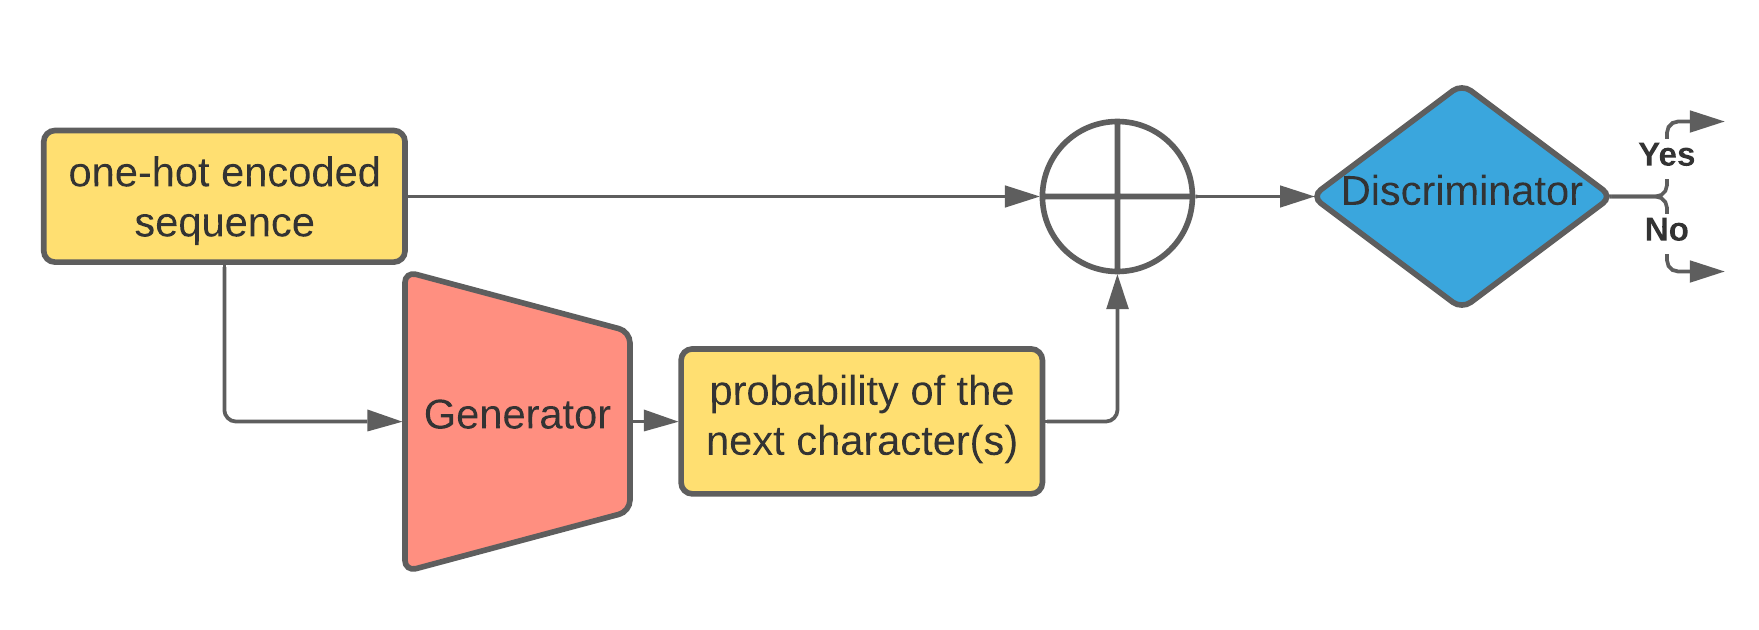

# Text generator version 3, (with Gumbel-Softmax layer)
https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/RelaxedOneHotCategorical

The generator version 2 is used with RelaxedOneHotCategorical additional layer. 

In [ ]:
class GumbelGenerator(tf.keras.Model):
  def __init__(self, vocab_size, temperature):
    super().__init__(self)
    self.temperature = temperature 
    self.generator = tf.keras.Sequential([
      tf.keras.layers.LSTM(units=100, return_sequences=True),
      tf.keras.layers.Dense(100), 
      tf.keras.layers.Dense(vocab_size)   
    ], name = 'GumbelGenerator' )

  
  
  def call(self, inputs):
    x = inputs
    x = self.generator(x)
    RelaxedOneHotCategorical = tfp.distributions.RelaxedOneHotCategorical(temperature=self.temperature, logits=x)
    x = RelaxedOneHotCategorical.sample()
    return x

In [ ]:
temperature = 0.5
text_generator_v3 = GumbelGenerator(vocab_size = dictionary_lenth, temperature = temperature)

In [ ]:
# gen_v3_loss = tf.losses.categorical_crossentropy
text_generator_v3.compile(optimizer='adam', loss=tf.losses.categorical_crossentropy)
text_generator_v3.fit(x = one_hot_x, y = one_hot_y, epochs=6)

text_generator_v3.temperature = 0.25
text_generator_v3.fit(x = one_hot_x, y = one_hot_y, epochs=5)

text_generator_v3.temperature = 0.1
text_generator_v3.fit(x = one_hot_x, y = one_hot_y, epochs=4)

text_generator_v3.temperature = 0.01
text_generator_v3.fit(x = one_hot_x, y = one_hot_y, epochs=3)

text_generator_v3.temperature = 0.001
text_generator_v3.fit(x = one_hot_x, y = one_hot_y, epochs=2)

Epoch 1/5
760/760 [==============================] - 12s 11ms/step - loss: 4.1573
Epoch 2/5
760/760 [==============================] - 8s 11ms/step - loss: 1.0003
Epoch 3/5
760/760 [==============================] - 8s 11ms/step - loss: 0.8609
Epoch 4/5
760/760 [==============================] - 8s 11ms/step - loss: 0.7982
Epoch 5/5
760/760 [==============================] - 8s 11ms/step - loss: 0.7526
Epoch 1/4
760/760 [==============================] - 8s 11ms/step - loss: 0.7038
Epoch 2/4
760/760 [==============================] - 8s 11ms/step - loss: 0.6693
Epoch 3/4
760/760 [==============================] - 8s 11ms/step - loss: 0.6356
Epoch 4/4
760/760 [==============================] - 8s 11ms/step - loss: 0.6018
Epoch 1/3
760/760 [==============================] - 8s 11ms/step - loss: 0.5711
Epoch 2/3
760/760 [==============================] - 8s 11ms/step - loss: 0.5420
Epoch 3/3
760/760 [==============================] - 8s 11ms/step - loss: 0.5136
Epoch 1/2
760/760 [========

In [ ]:
start_text = 'Controller ready'
encoded_start_text=text_to_numbers(char_to_index, start_text)
one_hot_start_text = np.array([array_of_int_to_one_hot(encoded_start_text, one_hot_matrix)])

one_hot_pred = text_generator_v3(one_hot_start_text)  
pred_array = tf.squeeze(one_hot_pred).numpy()
print('pred_array.shape',pred_array.shape)

ids = [np.argmax(seq) for seq in pred_array]
gen_text = numbers_to_text(index_to_char, ids)
print("Generated text:", gen_text)

pred_array.shape (16, 54)
Generated text: ontroller_ready.


In [ ]:
last_ch_v3 = pred_array[-1]
last_ch_v3

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0.], dtype=float32)

In [ ]:
pred_lenth = 300

# Convert start test to numbers
encoded_start_text=text_to_numbers(char_to_index, start_text)

gen_seq = encoded_start_text
for _ in range(pred_lenth):
  # print(gen_seq)
  one_hot_gen_seq = np.array([array_of_int_to_one_hot(gen_seq, one_hot_matrix)])  
  one_hot_pred = text_generator_v3(one_hot_gen_seq)  
  pred_array = tf.squeeze(one_hot_pred).numpy()
  
  ids = [np.argmax(seq) for seq in pred_array]
  # ids = [np.random.choice(dictionary_lenth, p=seq) for seq in pred_array]
  pred = ids[-1]

  gen_seq = np.append(gen_seq, pred)

gen_text = numbers_to_text(index_to_char, gen_seq)
print(gen_text)

Controller ready...
2139.43: Passenger_42: Activity time 81.227260372436
2736.48: Controller_0: Closing doors
2239.58: Controller_0: Checont eler_0: Picondl
757.46: Controller_0: Closing doors
700.26: Controller_0: Elevator departing to floor floor 6
1574.46: Controller_0: Current elevator floor: 5
1506.46: Control


But to create a new sequence, we still need to run the generator many times.